# Final Project CS209b
## Autoregression Flu - April 30
### Benjamin Levy, Will Fried, Dimitris Vamvourellis & Matthieu Meeus

In this notebook, we will build the baseline model for predicting the flu rate over time for all states. Therefore we will us the easy and intuitive model for time series: autoregession. We will first load the data, briefly introduce AutoRegressive models and then apply both a 1 and 5-weeks ahead prediction model. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

### 1. Load the Data

In [2]:
flu_data = pd.read_csv('flu_ground_truth_imputed.csv')
flu_data = flu_data.reindex(sorted(flu_data.columns), axis=1)
flu_data.head()

,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,2.13477,0.674721,0.696056,1.95412,0.660684,0.078309,0.100125,1.60490,0.414938,1.28205,...,1.102750,0.274655,2.06514,0.747696,1.47641,1.14343,0.510041,1.59741,0.465022,0.632911
1,2.05999,0.749939,0.674157,2.15266,0.628621,0.238095,0.368550,1.71307,1.457980,1.45089,...,0.793794,0.499492,2.09394,0.410939,1.35777,1.23653,1.040070,1.58968,0.581832,0.440621
2,1.94224,0.953365,0.514217,2.24173,0.804020,0.374158,0.337025,2.01249,1.408140,1.56607,...,0.791023,0.499550,2.10072,0.440583,1.48221,1.22545,0.904393,1.52672,1.188220,0.441798
3,2.27650,0.888804,0.413650,1.91748,0.909658,0.333542,0.460494,2.38747,1.280070,1.45762,...,0.801311,0.401638,2.20655,0.755957,1.44393,1.26902,0.955110,1.81171,1.010490,0.490305
4,2.83371,1.185730,1.090280,2.52326,0.971705,0.396743,0.222332,2.65614,1.827240,1.48930,...,0.779833,0.528096,2.36381,0.651859,1.25276,1.26547,0.786370,1.83986,1.096490,0.566636


Text(0.5, 1.0, 'Flu infection rate over time since week 40 of 2010')

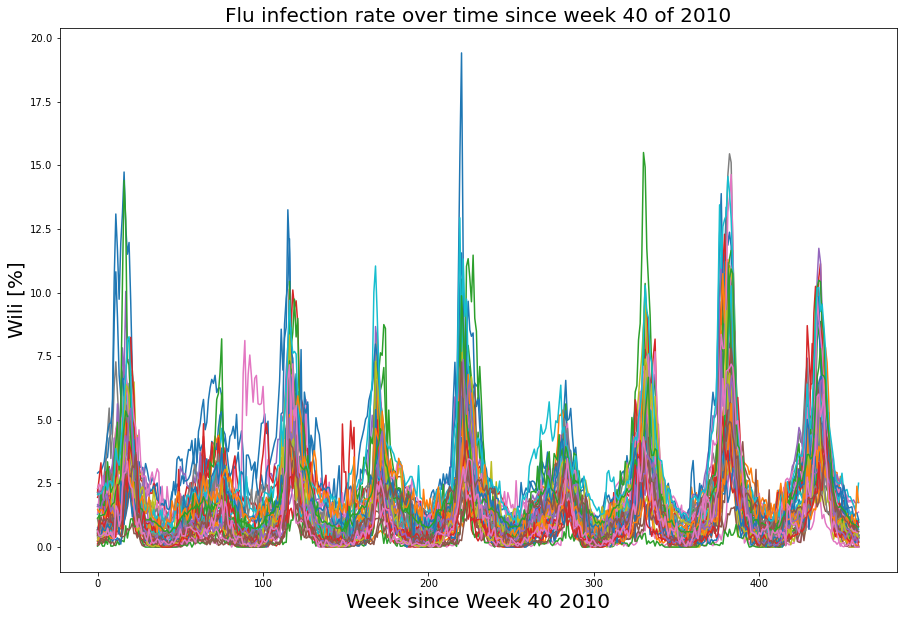

In [3]:
plt.figure(figsize = (15,10))
for state_name in flu_data.columns:
    if state_name != 'time':
        plt.plot(range(len(flu_data)), flu_data[state_name])
plt.xlabel('Week since Week 40 2010', fontsize = 20)
plt.ylabel('Wili [%]', fontsize = 20)
plt.title('Flu infection rate over time since week 40 of 2010', fontsize = 20)

In [4]:
# check the NaN
nans = []
for state_name in flu_data.columns:
    if state_name != 'time':
        nans_state = flu_data[state_name].isna().sum()
        if nans_state != 0:
            print('For {}, there are {} NaNs'.format(state_name, nans_state))
            nans.append(nans_state)
if len(nans) == 0:
    print('There are no Nans!')

There are no Nans!


### 2. An autoregressive (AR) Model

In an Autoregressive model, it is assumed that the output variable depends linearly on its previous values in time. Or mathematically:

$$X_{t}=c+\sum _{{i=1}}^{p}\varphi _{i}X_{{t-i}}+\varepsilon _{t}\,$$

Where $p$ is the order of the AR model, which comes down to the number of previous values that are relevant for the prediction of the future value. This is model that is commonly used for time series but it relies on the assumption that the all values are strongly correlation with the next value. Let's first have a look at that using a lagplot. 

Text(0.5, 1.0, 'Lagplot for all states')

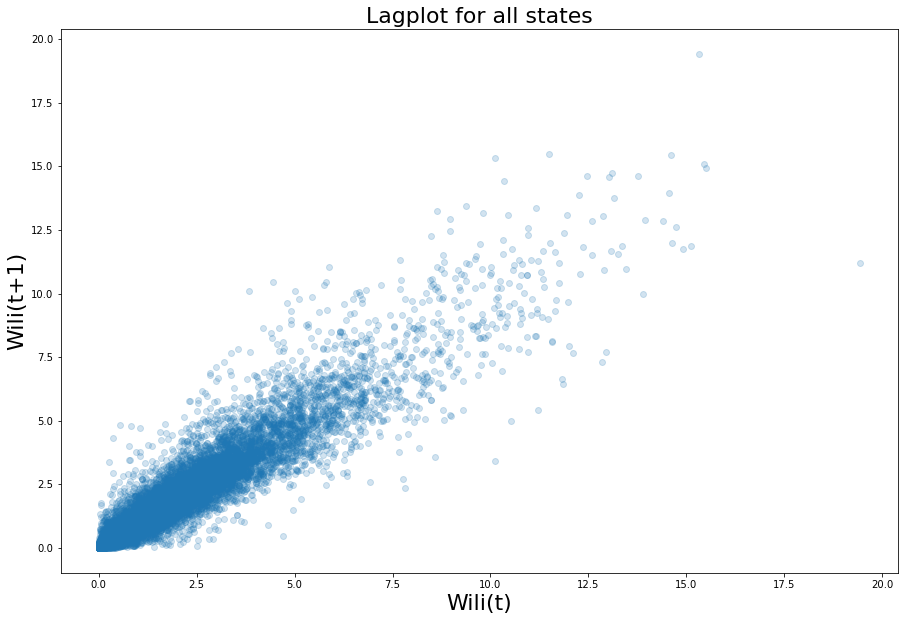

In [5]:
plt.figure(figsize = (15,10))
for state_name in flu_data.columns:
    pd.plotting.lag_plot(flu_data[state_name], alpha = 0.2)
    
plt.xlabel('Wili(t)', fontsize = 22)
plt.ylabel('Wili(t+1)', fontsize = 22)
plt.title('Lagplot for all states', fontsize = 22)

This looks very correlated! Let's quantify this for every state using the correlation coefficient. 

Text(0.5, 1.0, 'Autocorrelation coefficient per state for lag = 1')

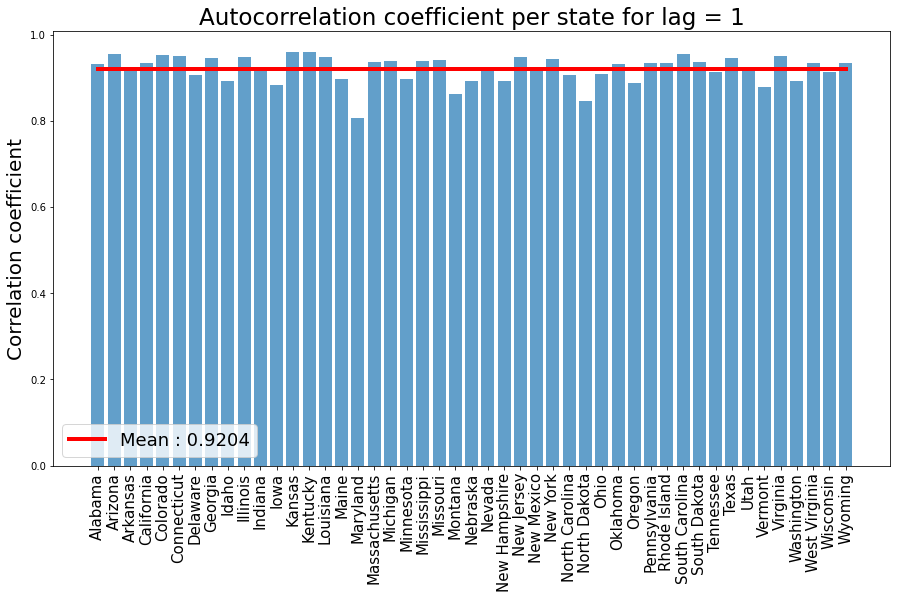

In [6]:
auto_corr = dict()

for state_name in flu_data.columns:
    if state_name != 'time':
        values = flu_data[state_name]
        df = pd.concat([values.shift(1), values], axis = 1)
        corr = df.corr().values[0,1]
        auto_corr[state_name] = corr
mean = np.mean(list(auto_corr.values()))
plt.figure(figsize = (15,8))
plt.bar(range(len(auto_corr)), list(auto_corr.values()), align='center', alpha = 0.7)
plt.plot(range(len(auto_corr)), np.ones(len(auto_corr))*mean,
        c = 'red', label = 'Mean : {}'.format(np.round(mean,4)), linewidth=4)
plt.legend(fontsize = 18)
plt.xticks(range(len(auto_corr)), list(auto_corr.keys()), rotation = 90, fontsize = 15)
plt.ylabel('Correlation coefficient', fontsize = 20)
plt.title('Autocorrelation coefficient per state for lag = 1', fontsize = 23)

Text(0.5, 1.0, 'Autocorrelation vs lag for all states')

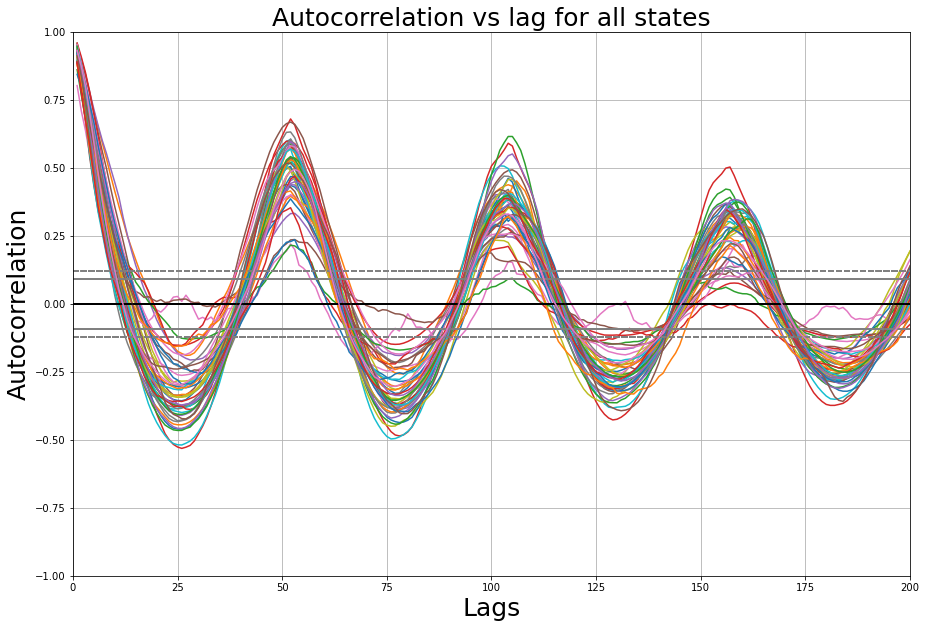

In [7]:
plt.figure(figsize = (15,10))
for state_name in flu_data.columns:
    pd.plotting.autocorrelation_plot(flu_data[state_name])
plt.xlim([0,200])
plt.xlabel('Lags', fontsize = 25)
plt.ylabel('Autocorrelation', fontsize = 25)
plt.title('Autocorrelation vs lag for all states', fontsize = 25)

### 3. Build the AR model for the flu

After some EDA, we know that the time series are decently autocorrelated and are thus well suited for a AR prediction model. Let's now build two AR models: 

- One that uses the previous N data points to predict the next Wili rate in state i. 
- One that uses the previous N data to predict the Wili rate in state i 5 weeks in the future. 

Note that N, the number of lags in time to include as predictors, is a hyperparamater to tune. 

#### 3.1 One week ahead prediction

In [8]:
n_test = 50
lags = range(1,50)
av_mses_train = []
av_mses_test = []
for lag in lags:
    mses_train = []
    mses_test = []
    for state_name in flu_data.columns:
        X = flu_data[state_name].values
        train, test = X[:len(X)-n_test], X[len(X) - n_test:]
        model = AutoReg(train, lags = lag)
        model_fit = model.fit()
        # make predictions
        predictions_train = model_fit.predict(start=lag, end=len(train)-1, dynamic=False)
        predictions_test = model_fit.predict(start=len(train), end=len(train)+len(test)-1, 
                                             dynamic=False)
        mse_train = mean_squared_error(train[lag:], predictions_train)
        mse_test = mean_squared_error(test, predictions_test)
        mses_train.append(mse_train)
        mses_test.append(mse_test)
    av_mse_train = np.mean(mses_train)
    av_mses_train.append(av_mse_train)
    av_mse_test = np.mean(mses_test)
    av_mses_test.append(av_mse_test)
    #print('For {} lags, the average test MSE is: {}'.format(lag, av_mse))

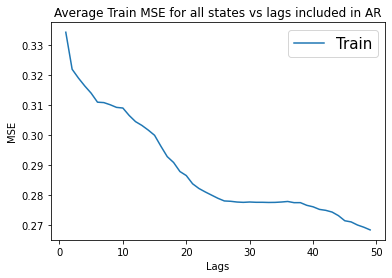

Text(0.5, 1.0, 'Average Test MSE for all states vs lags included in AR')

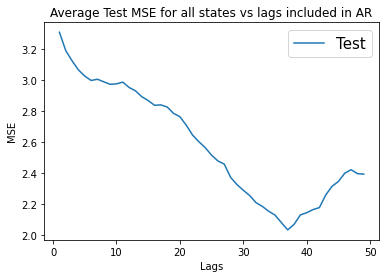

In [9]:
plt.figure()
plt.plot(lags, av_mses_train, label = 'Train')
plt.xlabel('Lags')
plt.ylabel('MSE')
plt.legend(fontsize = 15)
plt.title('Average Train MSE for all states vs lags included in AR')
plt.show()
plt.figure()
plt.plot(lags, av_mses_test, label = 'Test')
plt.xlabel('Lags')
plt.ylabel('MSE')
plt.legend(fontsize = 15)
plt.title('Average Test MSE for all states vs lags included in AR')

In [10]:
opt_lag = np.argmin(av_mses_test)
opt_lag

36

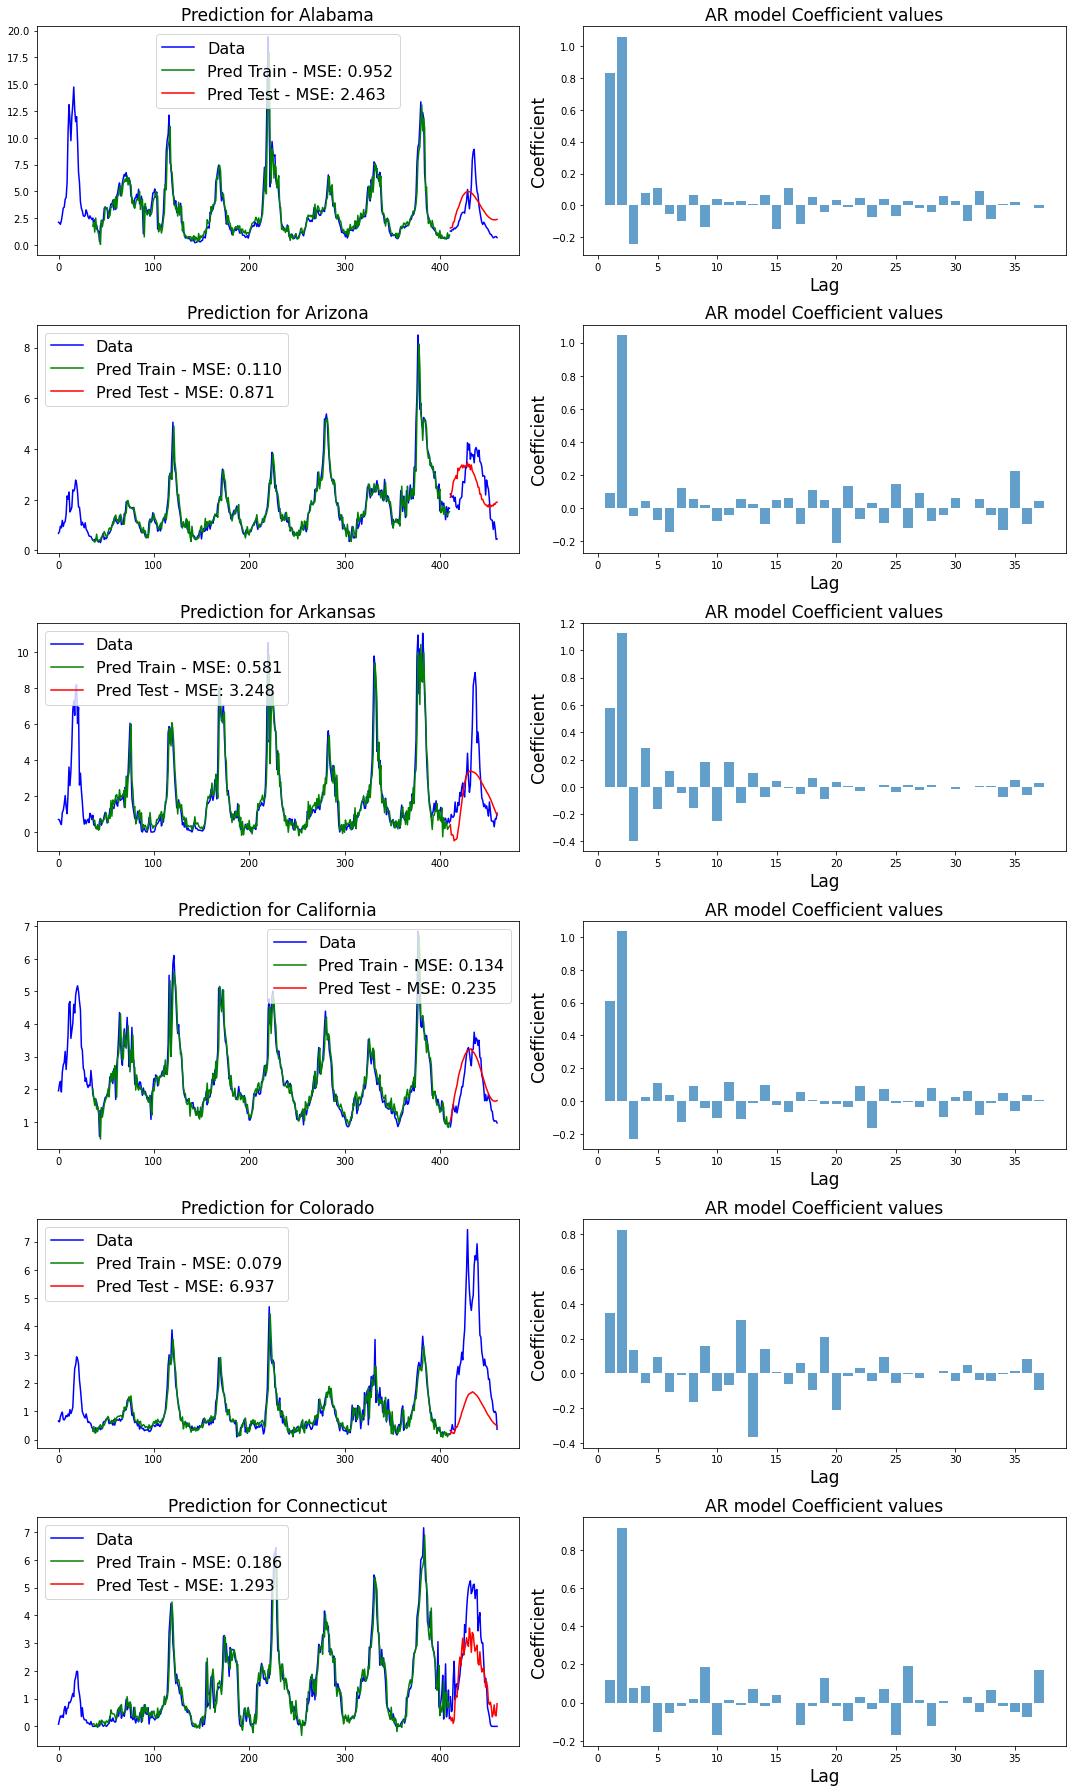

In [33]:
n_test = 50
lag = opt_lag

fig, ax = plt.subplots(6, 2, figsize=(15,25))

for i, state_name in enumerate(flu_data.columns[:6]):
    X = flu_data[state_name].values
    train, test = X[:len(X)-n_test], X[len(X) - n_test:]
    model = AutoReg(train, lags = lag)
    model_fit = model.fit()
    coefs = model_fit.params
    # make predictions
    predictions_train = model_fit.predict(start=lag, end=len(train)-1, dynamic=False)
    predictions_test = model_fit.predict(start=len(train), end=len(train)+len(test)-1, 
                                         dynamic=False)
    mse_train = mean_squared_error(train[lag:], predictions_train)
    mse_test = mean_squared_error(test, predictions_test)
        
    ax[i,0].plot(range(len(train)), train, label = 'Data', c = 'blue')
    ax[i,0].plot(range(len(train), len(train)+len(test)), test, c = 'blue')
    ax[i,0].plot(range(lag, len(train)), predictions_train, 
                 label = 'Pred Train - MSE: %.3f' % mse_train, c = 'green')
    ax[i,0].plot(range(len(train), len(train)+len(test)), 
                 predictions_test, label = 'Pred Test - MSE: %.3f' % mse_test, c = 'red')
    ax[i,0].legend(fontsize = 16)
    ax[i,0].set_title('Prediction for {}'.format(state_name), fontsize = 17)
    ax[i,1].bar(range(1,len(coefs)+1), coefs, align='center', alpha = 0.7)
    ax[i,1].set_xlabel('Lag', fontsize = 17)
    ax[i,1].set_ylabel('Coefficient', fontsize = 17)
    ax[i,1].set_title('AR model Coefficient values', fontsize = 17)
plt.tight_layout()

In [34]:
# compute the average MSE for all states on the test set
# using the optimal lag and dynamic = true

n_test = 50
lag = opt_lag
mses_train = []
mses_test = []

for i, state_name in enumerate(flu_data.columns):
    X = flu_data[state_name].values
    train, test = X[:len(X)-n_test], X[len(X) - n_test:]
    model = AutoReg(train, lags = lag)
    model_fit = model.fit()
    
    # make predictions
    predictions_train = model_fit.predict(start=lag, end=len(train)-1, dynamic=False)
    predictions_test = model_fit.predict(start=len(train), end=len(train)+len(test)-1, 
                                         dynamic=False)
    mse_train = mean_squared_error(train[lag:], predictions_train)
    mse_test = mean_squared_error(test, predictions_test)
        
    mses_train.append(mse_train)
    mses_test.append(mse_test)

print('The average train MSE for 1-week ahead AR model is: {}'.format(np.mean(mses_train)))
print('The average test MSE for 1-week ahead AR model is: {}'.format(np.mean(mses_test)))

The average train MSE for 1-week ahead AR model is: 0.2777467672090904
The average test MSE for 1-week ahead AR model is: 2.0828557527605183


#### 3.2 5-weeks ahead AR model

We will now try to use the same autoregressive approach to predict the Wili rate 5 weeks ahead in time. 

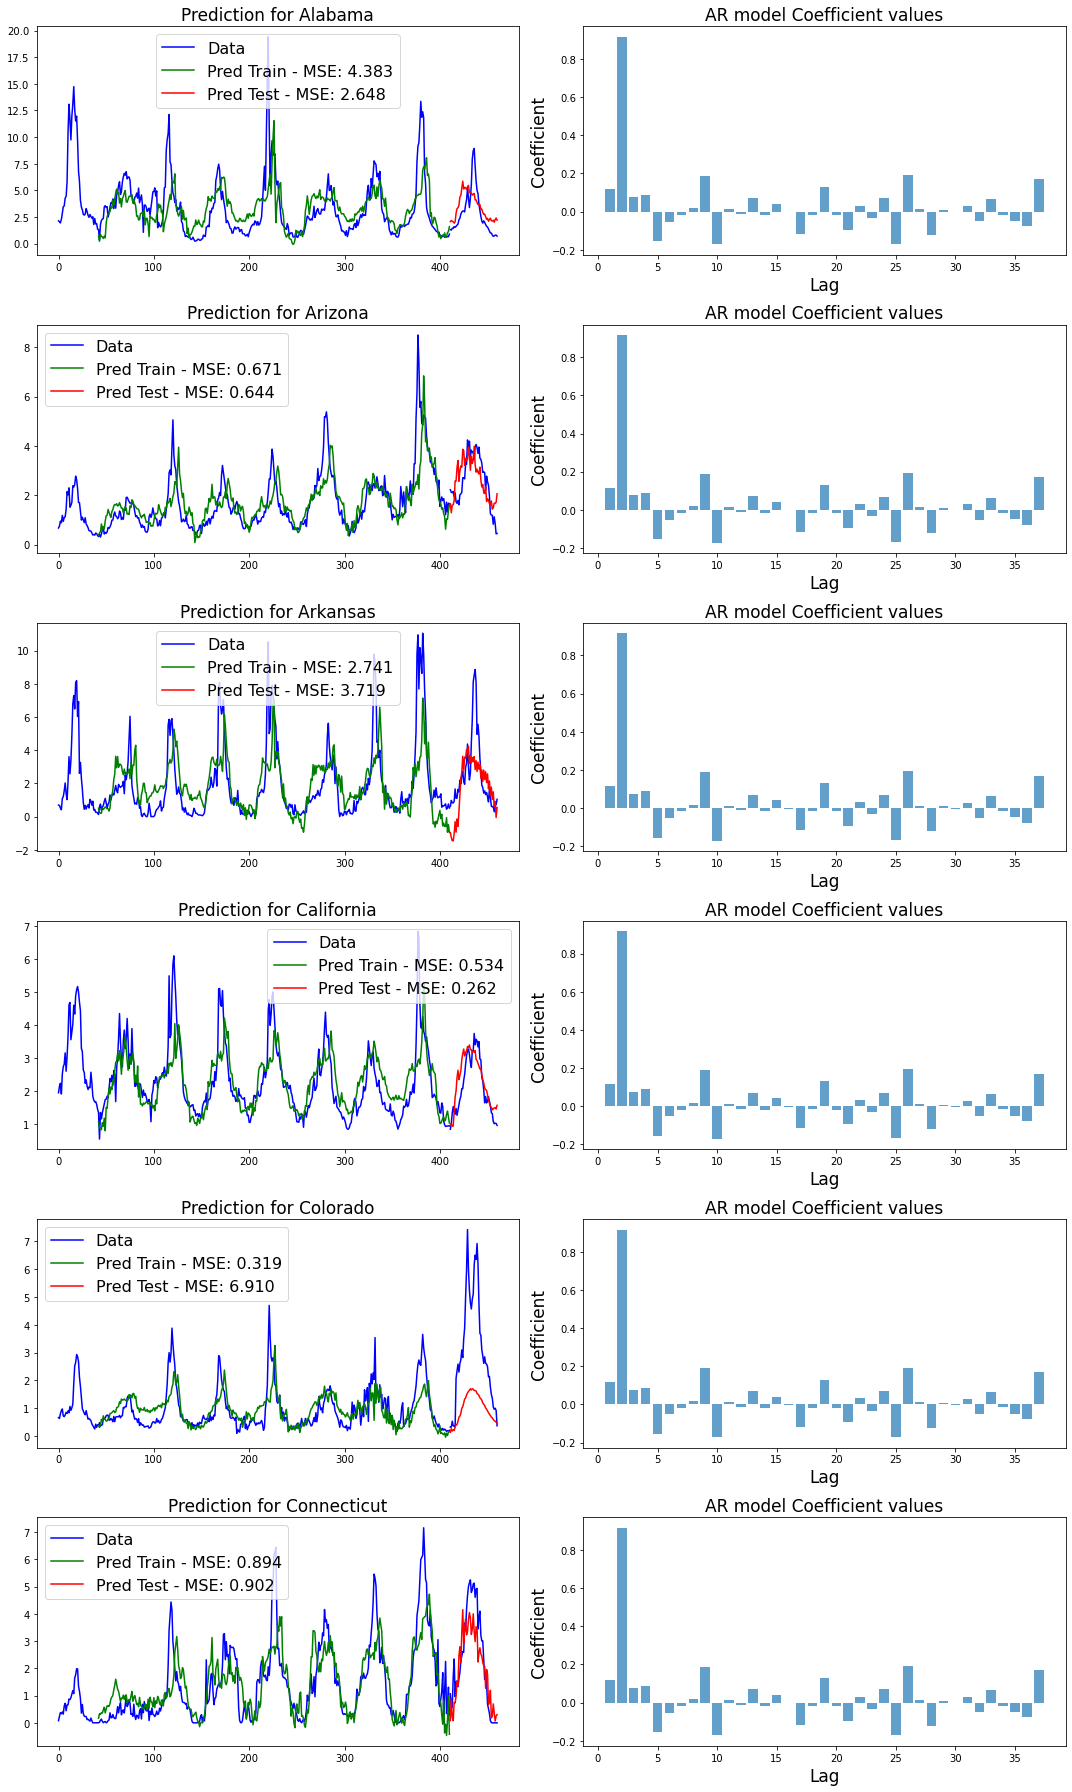

In [38]:
# note that the AutoReg module can still be used for this
# if we just make sure the lags 1-6 are not included

five_weeks_dataset = dict()
pred_ahead = 5

fig, ax = plt.subplots(6, 2, figsize=(15,25))
for i, state_name in enumerate(flu_data.columns[:6]):
    X = flu_data[state_name].values
    train, test = X[:len(X)-n_test], X[len(X) - n_test:]
    model = AutoReg(train, lags = range(pred_ahead + 1, lag+pred_ahead+1))
    model_fit = model.fit()
    
    # make predictions
    predictions_train = model_fit.predict(start=lag+pred_ahead+1, end=len(train)-1, dynamic=False)
    predictions_test = model_fit.predict(start=len(train), end=len(train)+len(test)-1, 
                                         dynamic=False)
    
    mse_train = mean_squared_error(train[lag+pred_ahead+1:], predictions_train)
    mse_test = mean_squared_error(test, predictions_test)
        
    ax[i,0].plot(range(len(train)), train, label = 'Data', c = 'blue')
    ax[i,0].plot(range(len(train), len(train)+len(test)), test, c = 'blue')
    ax[i,0].plot(range(lag+pred_ahead+1, len(train)), predictions_train, 
                 label = 'Pred Train - MSE: %.3f' % mse_train, c = 'green')
    ax[i,0].plot(range(len(train), len(train)+len(test)), 
                 predictions_test, label = 'Pred Test - MSE: %.3f' % mse_test, c = 'red')
    ax[i,0].legend(fontsize = 16)
    ax[i,0].set_title('Prediction for {}'.format(state_name), fontsize = 17)
    ax[i,1].bar(range(1,len(coefs)+1), coefs, align='center', alpha = 0.7)
    ax[i,1].set_xlabel('Lag', fontsize = 17)
    ax[i,1].set_ylabel('Coefficient', fontsize = 17)
    ax[i,1].set_title('AR model Coefficient values', fontsize = 17)
plt.tight_layout()

In [43]:
# compute the average MSE for all states on the test set
# using the optimal lag and dynamic = true

n_test = 50
lag = opt_lag
mses_train = []
mses_test = []

for i, state_name in enumerate(flu_data.columns):
    X = flu_data[state_name].values
    train, test = X[:len(X)-n_test], X[len(X) - n_test:]
    model = AutoReg(train, lags = range(pred_ahead + 1, lag+pred_ahead+1))
    model_fit = model.fit()
    
    # make predictions
    predictions_train = model_fit.predict(start=lag+pred_ahead+1, end=len(train)-1, dynamic=False)
    predictions_test = model_fit.predict(start=len(train), end=len(train)+len(test)-1, 
                                         dynamic=False)
    
    mse_train = mean_squared_error(train[lag+pred_ahead+1:], predictions_train)
    mse_test = mean_squared_error(test, predictions_test)
        
    mses_train.append(mse_train)
    mses_test.append(mse_test)

print('The average train MSE for 5-week ahead AR model is: {}'.format(np.mean(mses_train)))
print('The average test MSE for 5-week ahead AR model is: {}'.format(np.mean(mses_test)))

The average train MSE for 5-week ahead AR model is: 1.329626700221455
The average test MSE for 5-week ahead AR model is: 2.8059241634532706
